In [34]:

import tensorflow as tf
import cv2
import pyautogui
import numpy as np
from keras_cv.models import YOLOV8Detector
from keras_cv import bounding_box
from keras_cv import visualization
import os
from tensorflow.keras.models import load_model
import keras_cv
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#HYPERPARAMETERS 

SPLIT_RATIO = 0.2
BATCH_SIZE = 4
LEARNING_RATE = 0.001
EPOCH = 5
GLOBAL_CLIPNORM = 10.0

In [3]:
# Check TensorFlow Version
print("TensorFlow Version:", tf.__version__)

# Check for GPU availability
print("GPU Available:", tf.test.is_gpu_available())

# List the names of available GPUs
print("GPU Device Names:", tf.config.list_physical_devices('GPU'))


TensorFlow Version: 2.13.1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU Available: True
GPU Device Names: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-09-27 12:25:03.229053: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-27 12:25:03.241864: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-27 12:25:03.242164: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:

# Load the model
custom_objects = {'YOLOV8Detector': YOLOV8Detector}
loaded_yolo = load_model('./goblin-detector-model_v1', custom_objects=custom_objects, compile=False)

# Manually compile the model
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

loaded_yolo.compile(
    optimizer=optimizer,
    classification_loss="binary_crossentropy",
    box_loss="ciou"
)

2023-09-27 12:25:03.965634: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-27 12:25:03.966959: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-27 12:25:03.967333: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [48]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

def generate_dataset(dataframe):
  grouped = dataframe.groupby('filename')
  bbox = []
  classes = []
  image_paths = []

  for name, group in grouped:
      bbox.append(group[['xmin', 'ymin', 'xmax', 'ymax']].values.tolist())
      classes.append(group['class_Goblin'].values.tolist())
      image_paths.append(name)


  bbox = tf.ragged.constant(bbox)
  classes = tf.ragged.constant(classes)
  image_paths = tf.convert_to_tensor(image_paths)

  # Create tf dataset
  data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))
  return data

def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}


def get_test_data(directory="./test_data"):
    # Get all files in the directory
    files = os.listdir(directory)

    # Filter for .jpg files
    image_paths = [f for f in files if f.endswith(".jpg")]

    # Load annotations and filter for images present in the directory
    df = pd.read_csv(os.path.join(directory, "_annotations.csv"))
    df["class"] = df["class"].str.capitalize()
    df = pd.get_dummies(df, columns=['class'])
    df = df[df["filename"].isin(image_paths)]

    # Update filename column with the full path
    df["filename"] = df["filename"].apply(lambda x: os.path.join(directory, x))
    print(df.head())
    # Create a dataset from the image paths
    data = generate_dataset(df)

    return data

def visualize_detections(model, dataset, bounding_box_format):
    inputs = next(iter(dataset.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]

    y_pred = model.predict(images)
    
    # Define the Goblin class mapping
    class_mapping = {0: "Goblin"}
    
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=bounding_boxes,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping
    )
    


In [49]:
loaded_yolo.input_shape

(None, None, None, 3)

                                              filename  width  height  xmin  \
154  ./test_data/image12_png.rf.3b32c5f71b10014ad5c...   1280    1024   286   
155  ./test_data/image12_png.rf.3b32c5f71b10014ad5c...   1280    1024   443   
156  ./test_data/image12_png.rf.3b32c5f71b10014ad5c...   1280    1024   536   
157  ./test_data/image12_png.rf.3b32c5f71b10014ad5c...   1280    1024   800   
158  ./test_data/image12_png.rf.3b32c5f71b10014ad5c...   1280    1024  1077   

     ymin  xmax  ymax  class_Goblin  
154   472   354   561          True  
155   722   538   836          True  
156   774   641   883          True  
157   190   852   254          True  
158   259  1146   327          True  
1/1 [==============================] - 1s 569ms/step


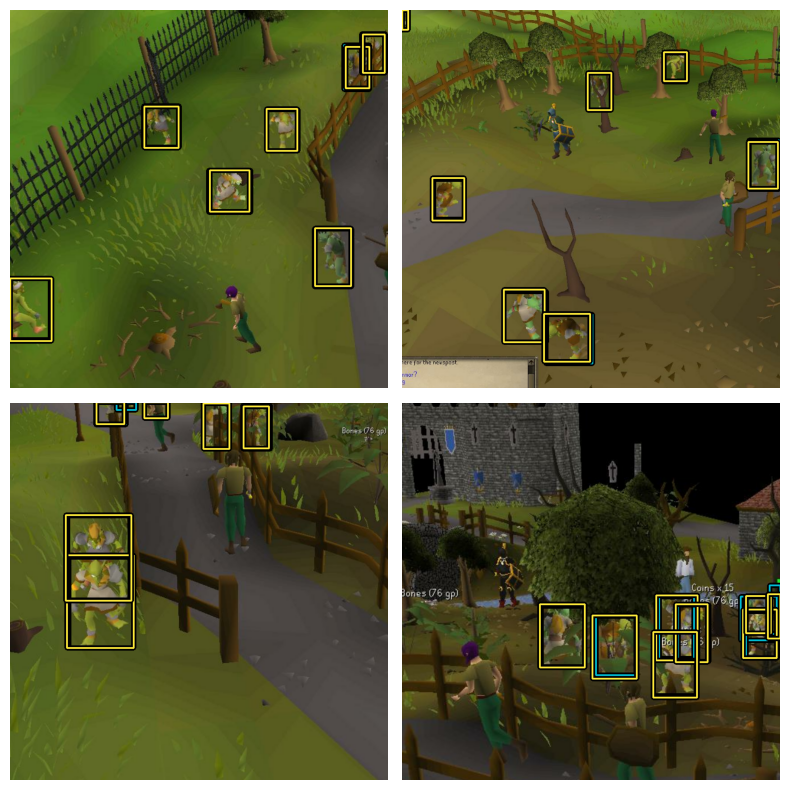

In [50]:
#check if detections are ok with test data
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy",
)
test_data = get_test_data()
test_data = test_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
test_data  = test_data.shuffle(BATCH_SIZE * 4)
test_data = test_data.ragged_batch(BATCH_SIZE, drop_remainder=True)
test_data = test_data.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

# Visualize detections on the test dataset
visualize_detections(loaded_yolo, dataset=test_data, bounding_box_format="xyxy")

In [65]:
import cv2
import numpy as np
from mss import mss

screen_width, screen_height = pyautogui.size()

def start_detecting():
    sct = mss()
    monitor = {"top": 0, "left": 0, "width": screen_width, "height": screen_height}

    while True:
        # Capture screen directly into memory
        screenshot = sct.grab(monitor)
        frame = np.array(screenshot)
        
        input_frame = cv2.resize(frame, (640, 640))
        input_frame = np.expand_dims(input_frame, axis=0)

        y_pred_dict = loaded_yolo.predict(input_frame)
        print(y_pred_dict)
        boxes, confidence, classes = y_pred_dict['boxes'][0], y_pred_dict['confidence'][0], y_pred_dict['classes'][0]
        for box, conf, cls in zip(boxes, confidence, classes):
            if conf == -1 or cls == -1:
                continue
            x1, y1, x2, y2 = map(int, box)
            
            # Transform coordinates
            x1 = int((x1 / 640) * screen_width)
            y1 = int((y1 / 640) * screen_height)
            x2 = int((x2 / 640) * screen_width)
            y2 = int((y2 / 640) * screen_height)

            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, str(cls), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

        cv2.imshow('Object Detection', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cv2.destroyAllWindows()

NameError: name 'q' is not defined

In [66]:


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Num GPUs Available: {len(gpus)}")
    for gpu in gpus:
        print(f"GPU: {gpu}")
    start_detecting()
else:
    print("No GPUs are available!")

Num GPUs Available: 1
GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1/1 [==============================] - 0s 190ms/step
{'boxes': array([[[-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
     